In [1]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
def solution(x, t, m, C):
    alpha = 1.0 / (m + 1)
    factor = t**(-alpha)
    inner = C - (m - 1) / (2 * m * (m + 1)) * x**2 / (t**(2 * alpha))
    return factor * np.maximum(inner, 0)**(1.0 / (m - 1))

In [3]:
def ic_func(x):
    x_space = x[:, 0:1]                
    return solution(x_space, t0, m, C) # analytic Barenblatt at t0

In [4]:
L = 15.0 
T = 1.0
t0 = 0.01 * T  
m = 2
C = 1

In [5]:
import deepxde as dde
import numpy as np


def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    um = u**m
    grad_um = dde.grad.jacobian(um, x, i=0, j=0)
    div_flux = dde.grad.jacobian(grad_um, x, i=0, j=0)
    return u_t - div_flux 



geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(t0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -L) and not np.isclose(x[1], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1], 0)

# условия нулевые на достаточно далеком иксе
bc_left = dde.DirichletBC(
    geomtime,
    lambda x: 0.0,           
    boundary_left,
    component=0,
)

bc_right = dde.DirichletBC(
    geomtime,
    lambda x: 0.0,         
    boundary_right,
    component=0,
)

def on_initial(x, on_initial):
    return on_initial and np.isclose(x[1], t0)

ic = dde.IC(geomtime, ic_func, on_initial, component=0)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc_left, bc_right, ic],
    num_domain=5000,
    num_boundary=500,
    num_initial=500,
)

net = dde.nn.FNN(
    [2] + [50] * 6 + [1],  
    "tanh",
    "Glorot normal",
)

In [6]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=5000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 1.117549 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.26e-03, 6.45e-01, 6.45e-01, 1.00e+00]    [8.26e-03, 6.45e-01, 6.45e-01, 1.00e+00]    []  


1000      [3.77e-02, 1.68e-06, 3.32e-07, 5.59e-02]    [3.77e-02, 1.68e-06, 3.32e-07, 5.59e-02]    []  
2000      [4.45e-01, 1.36e-04, 4.30e-05, 3.10e-02]    [4.45e-01, 1.36e-04, 4.30e-05, 3.10e-02]    []  
3000      [7.08e-03, 1.29e-06, 3.57e-07, 1.58e-02]    [7.08e-03, 1.29e-06, 3.57e-07, 1.58e-02]    []  
4000      [5.36e-03, 1.96e-06, 4.21e-06, 1.36e-02]    [5.36e-03, 1.96e-06, 4.21e-06, 1.36e-02]    []  
5000      [2.07e-02, 4.91e-05, 9.18e-06, 1.43e-02]    [2.07e-02, 4.91e-05, 9.18e-06, 1.43e-02]    []  

Best model at step 4000:
  train loss: 1.90e-02
  test loss: 1.90e-02
  test metric: []

'train' took 458.163276 s

Compiling model...
'compile' took 0.000617 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
5000      [2.07e-02, 4.91e-05, 9.18e-06, 1.43e-02]    [2.07e-02, 4.91e-05, 9.18e-06, 1.43e-02]    []  
6000      [4.45e-04, 3.67e-07, 6.31e-08, 2.09e-04]    [4.45e-04, 3.67e-07, 6.31e-08, 2.09e

Saving loss history to /home/ivan/MEPHI/nauchka/patlakov/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/patlakov/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/patlakov/test.dat ...


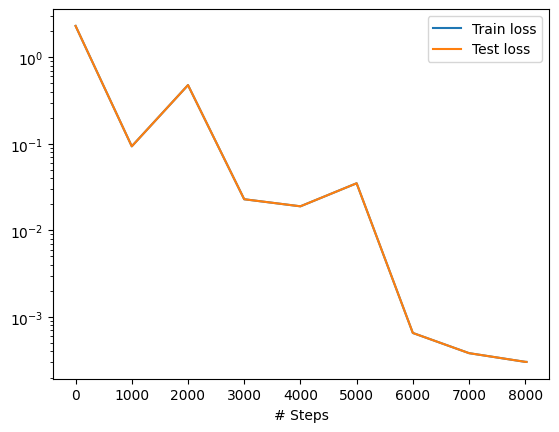

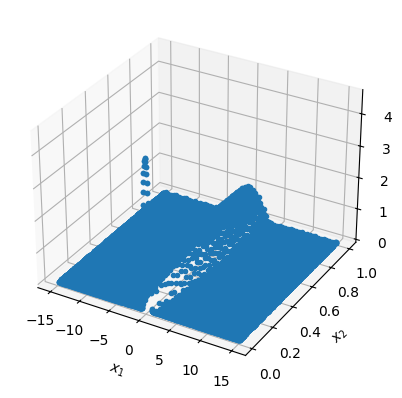

In [7]:
dde.saveplot(losshistory, train_state)

Text(0.5, 1.0, 'PINN error')

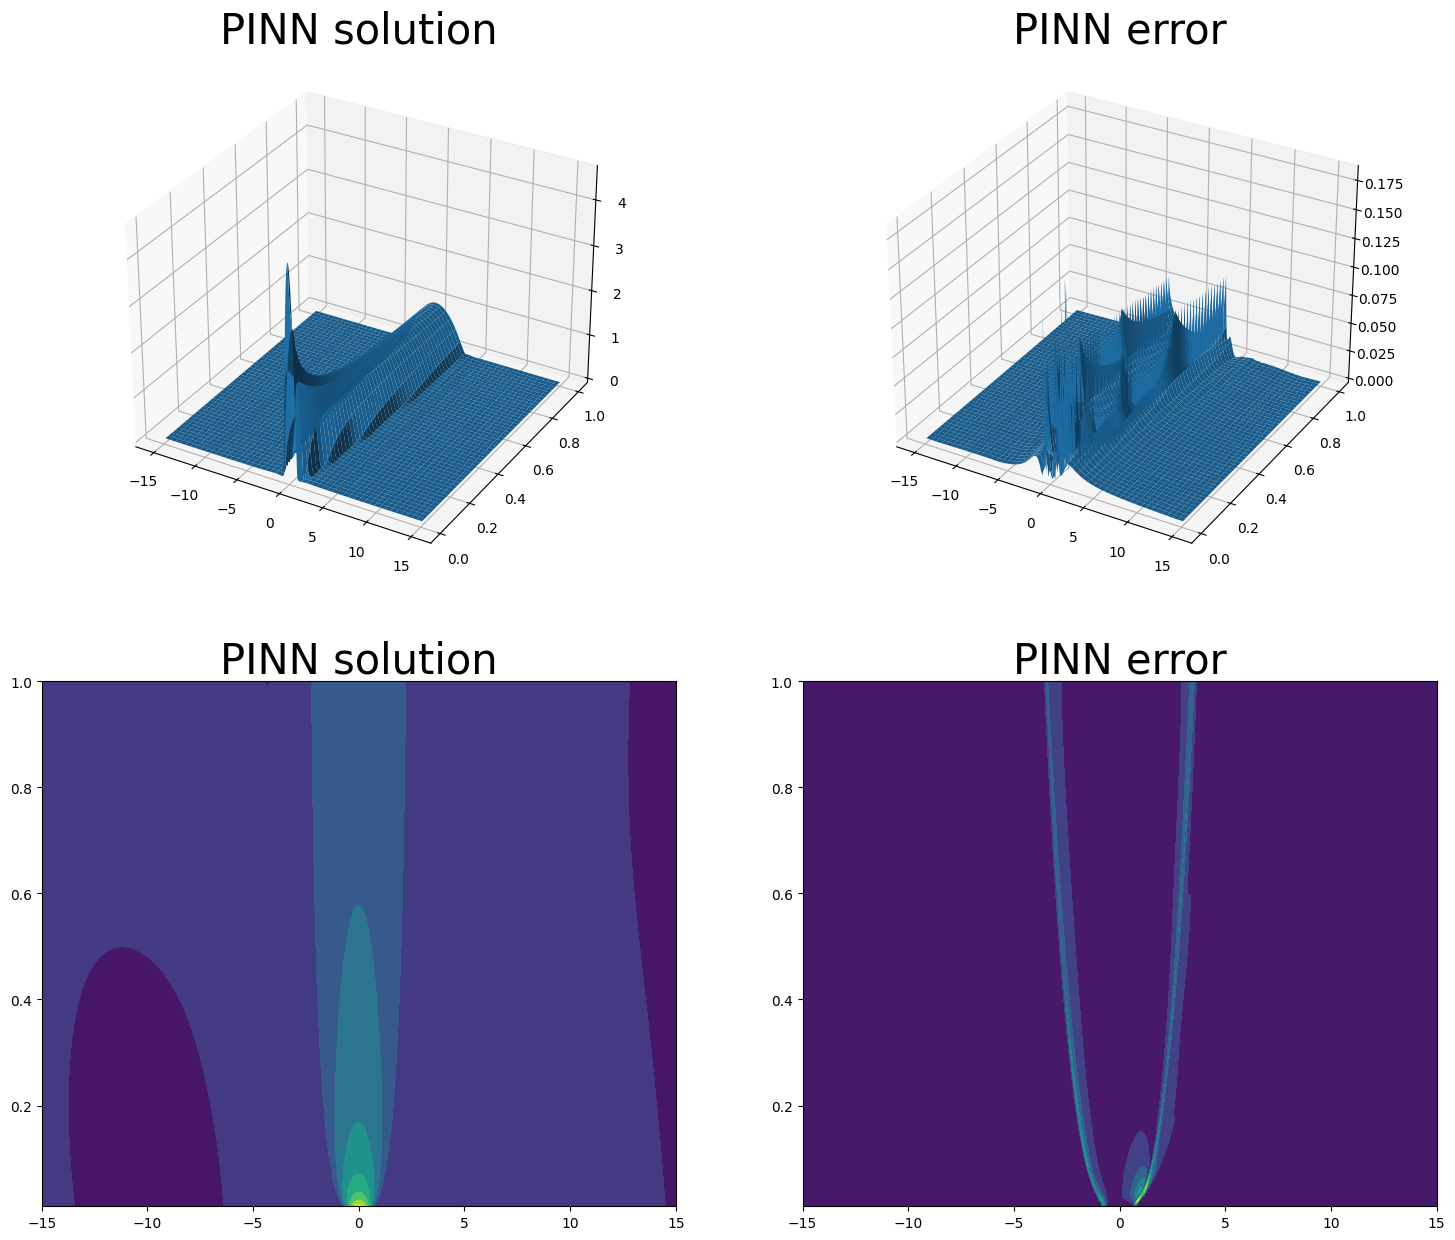

In [8]:
m     = 2.0      
C     = 1.0     

n_x   = 1000
n_t   = 1000


x_vals   = np.linspace(-L, L, n_x)    
t_vals   = np.linspace(t0, T, n_t)      
X, T_grid = np.meshgrid(x_vals, t_vals)
XT       = np.vstack((X.ravel(), T_grid.ravel())).T

U_pinn   = model.predict(XT).reshape(n_t, n_x)

U_bar    = solution(X, T_grid, m, C)

U_diff   = np.abs(U_pinn - U_bar)

fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(2,2,1, projection = '3d')
ax.plot_surface(X,T_grid,U_pinn)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,2, projection = '3d')
ax.plot_surface(X,T_grid,U_diff)
ax.set_title('PINN error',fontsize = 30)

ax = fig.add_subplot(2,2,3)
ax.contourf(X,T_grid,U_pinn)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,4)
ax.contourf(X,T_grid,U_diff)
ax.set_title('PINN error',fontsize = 30)


In [9]:

import pandas as pd

data = {'X':XT[:,0], 'T':XT[:,1], 'U':model.predict(XT).T[0]}

df = pd.DataFrame(data)
#df.to_csv('50x4_10000x500x500_m=2_PINN.csv')
